# Setup dataset

In [6]:
#%pip list --format freeze | grep -E '[a-zA-Z0-9_-]+==[0-9]+\.[0-9]+(\.[0-9]+)?' > requirements.txt

In [7]:
import pandas as pd
import os

ANNOTATIONS_PATH = 'data'
REPROCESSED_PATH = ANNOTATIONS_PATH+'/reprocessed'
with open(ANNOTATIONS_PATH+'/annotationsVSingle.txt','r') as file:
    annotations = [line for line in file.read().splitlines()[1:]]

sampleAnno = 0
def read_data(id: int):
    if '(A)' in annotations[id] or '(B)' in annotations[id]:
        folder, trial, fragId, _, OoM = annotations[id].replace(' ','').split(',')[:5]
    else:
        folder, trial, fragId, OoM = annotations[id].replace(' ','').split(',')[:4]
    file = os.path.join(REPROCESSED_PATH, folder, trial+'_frag'+fragId+'.csv')
    table = pd.read_csv(file)
    return table, OoM
dataTable,_ = read_data(sampleAnno)
dataTable.head()

,right_foot_X,right_foot_Y,right_foot_Z,left_foot_X,left_foot_Y,left_foot_Z,right_ank_X,right_ank_Y,right_ank_Z,left_ank_X,...,right_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,left_shoulder_X,left_shoulder_Y,left_shoulder_Z,head_X,head_Y,head_Z
0,0.603479,0.282036,0.196394,0.599149,0.282866,0.281366,0.634263,0.311879,0.185018,0.626746,...,0.178245,0.610581,0.753321,0.244585,0.608132,0.749503,0.310926,0.620697,0.841934,0.245584
1,0.603481,0.282036,0.196393,0.599149,0.282867,0.281366,0.634298,0.311807,0.185099,0.626744,...,0.178267,0.610508,0.753349,0.244600,0.608137,0.749526,0.310933,0.620695,0.841926,0.245566
2,0.603482,0.282037,0.196392,0.599149,0.282866,0.281365,0.634445,0.311722,0.185230,0.626739,...,0.178288,0.610425,0.753376,0.244616,0.608147,0.749552,0.310944,0.620691,0.841918,0.245548
3,0.603482,0.282036,0.196392,0.599152,0.282863,0.281364,0.633893,0.311849,0.184935,0.626735,...,0.178300,0.610346,0.753399,0.244627,0.608150,0.749578,0.310954,0.620685,0.841909,0.245532
4,0.603481,0.282040,0.196393,0.599150,0.282868,0.281363,0.634368,0.311826,0.185111,0.626724,...,0.178315,0.610267,0.753423,0.244642,0.608158,0.749599,0.310969,0.620681,0.841904,0.245516


In [8]:
def table_to_list_xyz_tables(table:pd.DataFrame,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]
    
def group_table_by_joints(table: pd.DataFrame) -> pd.DataFrame:
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

In [9]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.stats import iqr

def extractFeatures(features):
  raw_features = features.shape[1]
  arr = features
  energy = np.sqrt(np.sum(arr ** 2, axis=0))
  fft = np.fft.fft(arr, axis=0)
  amplitude_spectrum = np.abs(fft)
  phase_angle = np.angle(fft) 

  frq_info = [
              phase_angle[0, :],
              np.mean(fft.real, axis=0),
              np.max(fft.real, axis=0),
              np.argmax(fft.real, axis=0),
              np.min(fft.real, axis=0),
              np.argmin(fft.real, axis=0),
              skew(amplitude_spectrum, axis=0, bias=True),
              kurtosis(amplitude_spectrum, axis=0, bias=True),
  ] 

  frq_info = np.hstack(frq_info)
  mean = np.mean(arr, axis=0)
  var = np.var(arr, axis=0)
  kurt = kurtosis(arr, axis=0, bias=True)
  skew_ = skew(arr, axis=0, bias=True)
  corr = np.corrcoef(arr, rowvar=False)[np.triu_indices(raw_features,k=1)]
  mad = np.mean(np.abs(arr - mean), axis=0)
  sem = np.std(arr, axis=0) / np.sqrt(arr.shape[0])
  mi = np.min(arr, axis=0)
  ma = np.max(arr, axis=0)
  return np.hstack([mean,var,kurt,skew_,corr,mad,sem,energy,iqr(arr,axis=0),mi,ma,frq_info])

def get_feature_names(raw_features):#df, metadata):
  #df_raw_feat = df.columns
  new_names = [] #new_names = list(df_raw_feat[:metadata])
  #raw_features = df_raw_feat[metadata:]

  # Define the feature names based on the order they appear in extractFeatures
  new_names += [f"mean_{i}" for i in raw_features]
  new_names += [f"var_{i}" for i in raw_features]
  new_names += [f"kurt_{i}" for i in raw_features]
  new_names += [f"skew_{i}" for i in raw_features]
  new_names += [f"corr_{i_name}_{j_name}" for i, i_name in enumerate(raw_features[:-1]) for j, j_name in enumerate(raw_features[i+1:])]
  new_names += [f"mad_{i}" for i in raw_features]
  new_names += [f"sem_{i}" for i in raw_features]
  new_names += [f"energy_{i}" for i in raw_features]
  new_names += [f"iqr_{i}" for i in raw_features]
  new_names += [f"min_{i}" for i in raw_features]
  new_names += [f"max_{i}" for i in raw_features]

  new_names += [f"fft_phase_angle_{i}" for i in raw_features]
  new_names += [f"fft_mean_real_{i}" for i in raw_features]
  new_names += [f"fft_max_real_{i}" for i in raw_features]
  new_names += [f"fft_argmax_real_{i}" for i in raw_features]
  new_names += [f"fft_min_real_{i}" for i in raw_features]
  new_names += [f"fft_argmin_real_{i}" for i in raw_features]
  new_names += [f"fft_skew_amp_spec_{i}" for i in raw_features]
  new_names += [f"fft_kurt_amp_spec_{i}" for i in raw_features]

  return new_names

In [10]:
OoM_set = set([tuple(map(int, read_data(i)[1].strip('[]').split('-'))) for i in range(len(annotations))])
OoM_to_ord = dict(zip(sorted(list(OoM_set)),range(len(annotations))))
ord_to_OoM = dict(zip(range(len(annotations)),sorted(list(OoM_set))))
OoM_to_ord

{(1, 3): 0,
 (2, 4): 1,
 (3, 5): 2,
 (5, 7): 3,
 (6, 9): 4,
 (7, 8): 5,
 (8, 9): 6,
 (11, 13): 7,
 (12, 14): 8,
 (13, 15): 9,
 (15, 17): 10,
 (16, 19): 11,
 (17, 18): 12,
 (18, 19): 13,
 (18, 20): 14}

Works on single labels

In [11]:
import pandas as pd
from math import floor, ceil
import numpy as np

def timeframe_sampling(dataframe:pd.DataFrame, n_segments=200, strategy:str or None='slice'):
    assert strategy in ['crop', 'slice'] or strategy is None
    if strategy is None:
        return dataframe
    if len(dataframe) > n_segments:
        if strategy == 'crop':
            return dataframe[:n_segments]
        elif strategy == 'slice':
            mask = np.zeros(len(dataframe),bool)
            step_size = len(dataframe) / n_segments
            for i in range(n_segments):
                mask[ceil(step_size*i)] = True
            return dataframe.iloc[mask].reset_index(drop=True)
        
    slices = len(dataframe)-1
    nans_per_slice = floor((n_segments - len(dataframe)) / slices)
    df_with_nans = []
    counter = 0
    nan_row = pd.Series([np.nan] * len(dataframe.columns), index=dataframe.columns).to_frame().T
    for i in range(slices):
        df_with_nans.append(dataframe.iloc[i:i + 1])  # Original row
        df_with_nans.extend([nan_row]*nans_per_slice)  # NaN rows
        counter += nans_per_slice+1
    df_with_nans.append(dataframe.iloc[-1:])
    counter+=1
    df_with_nans = list(reversed(df_with_nans))
    for i in range(n_segments-counter):
        df_with_nans.insert(counter - (1 + nans_per_slice)*(i+1),nan_row)
    return pd.concat(list(reversed(df_with_nans))).reset_index(drop=True).interpolate(method='linear')

In [12]:
import numpy as np 
from tqdm.notebook import tqdm 

feature_names = get_feature_names([col[:-2] for col in dataTable.columns[::3]])

dataset = pd.DataFrame(index=range(len(annotations)), columns=feature_names+['OoM'])
lengths = []
for i in tqdm(range(len(annotations)),desc='Computing features for the dataset'):
    dataTable,OoM = read_data(i)
    lengths.append(len(dataTable))
    dataTable = timeframe_sampling(dataTable)
    centerOfMassPosTable = pd.concat([table.apply(lambda row: row.mean(),axis=1) for table in table_to_list_xyz_tables(dataTable)],axis=1)
    centerOfMassPosTable.columns = ['X','Y','Z']
    centerOfMassPosTable = centerOfMassPosTable.apply(lambda row: (row['X'], row['Y'], row['Z']), axis=1)
    tableByJoint = group_table_by_joints(dataTable)
    jointsDistFromCOM = tableByJoint.sub(centerOfMassPosTable,axis=0)
    jointsDistNorm = jointsDistFromCOM.applymap(lambda elem: np.linalg.norm(elem))
    jointsDistNormMin, jointsDistNormMax = jointsDistNorm.min(axis=0), jointsDistNorm.max(axis=0)
    jointsDistNorm = (jointsDistNorm-jointsDistNormMin)/(jointsDistNormMax-jointsDistNormMin)
    featureVector = extractFeatures(np.array(jointsDistNorm))
    dataset.loc[i] = np.hstack([featureVector,OoM_to_ord[tuple(map(int, OoM.strip('[]').split('-')))]])
dataset

Computing features for the dataset:   0%|          | 0/60 [00:00<?, ?it/s]

,mean_right_foot,mean_left_foot,mean_right_ank,mean_left_ank,mean_right_knee,mean_left_knee,mean_right_hip,mean_hip_central,mean_left_hip,mean_spine,...,fft_kurt_amp_spec_left_hand,fft_kurt_amp_spec_right_wrist,fft_kurt_amp_spec_left_wrist,fft_kurt_amp_spec_right_elbow,fft_kurt_amp_spec_left_elbow,fft_kurt_amp_spec_right_shoulder,fft_kurt_amp_spec_shoulder_center,fft_kurt_amp_spec_left_shoulder,fft_kurt_amp_spec_head,OoM
0,0.740791,0.742185,0.74924,0.747724,0.70568,0.738702,0.429271,0.38734,0.426352,0.524519,...,107.750101,90.650421,119.406008,130.524274,122.763097,172.831661,164.435694,124.220462,161.577798,12.0
1,0.723905,0.731171,0.756027,0.727694,0.767065,0.714302,0.452012,0.268672,0.372777,0.653726,...,109.926893,113.682653,69.421042,135.582303,128.696089,138.431351,141.424096,130.988994,140.595504,14.0
2,0.422592,0.342756,0.423562,0.327833,0.432352,0.330119,0.488518,0.649006,0.577469,0.621304,...,84.264922,100.335821,91.100883,133.391702,130.234212,144.562317,141.522594,113.402014,137.78153,5.0
3,0.557296,0.590079,0.636162,0.453695,0.549032,0.468817,0.572411,0.44078,0.393316,0.446172,...,75.108775,120.035551,61.869825,94.263729,96.049709,115.484635,130.649938,128.901816,89.276405,13.0
4,0.561828,0.561206,0.566439,0.564095,0.571035,0.566301,0.468747,0.448085,0.42858,0.453625,...,89.873939,94.643146,87.030536,82.045107,79.568714,72.852843,70.194362,69.337451,70.88042,8.0
5,0.43122,0.386518,0.396416,0.331946,0.346391,0.388627,0.536974,0.44783,0.585129,0.621907,...,35.883189,49.379806,33.349448,81.655071,76.923196,161.722901,160.346588,124.180676,118.983811,14.0
6,0.595595,0.394481,0.634425,0.392256,0.556082,0.45562,0.494501,0.696827,0.626372,0.567615,...,139.095992,119.007237,130.261816,107.456497,101.820683,90.768819,128.536137,95.831877,128.101274,2.0
7,0.39307,0.393477,0.416373,0.405597,0.414882,0.405173,0.641094,0.666045,0.657584,0.6809,...,69.621911,76.982085,75.078654,70.107885,116.439396,116.874802,125.401383,105.644656,105.896298,12.0
8,0.534739,0.458168,0.560128,0.479123,0.652953,0.599054,0.396397,0.477447,0.619647,0.635822,...,99.077195,97.518777,111.362073,88.542373,138.157589,121.833001,116.861226,113.964362,119.645428,3.0
9,0.596899,0.412877,0.550253,0.453722,0.500896,0.50565,0.576006,0.465558,0.309347,0.422226,...,104.682033,157.387275,118.921303,121.716418,139.849923,144.12161,84.21712,51.021969,147.410527,8.0


In [13]:
lengths = np.array(lengths)

import os
if not os.path.isfile(os.path.join(ANNOTATIONS_PATH,"Dataset.csv")):
    dataset.to_csv(os.path.join(ANNOTATIONS_PATH,"Dataset.csv"),index=False)


print(np.mean(lengths/100), np.std(lengths/100))

1.9596666666666667 1.4851149974178957


## Dataset distribution

In [14]:
import re

pattern = r'\[(.*?)\]'
matches = re.findall(pattern, '/n'.join(annotations))


results = {}
for element in matches:
    if ';' not in element:
        elem = (int(element.split('-')[0]),int(element.split('-')[1]))
        elem = tuple(elem) if elem[0] < elem[1] else tuple(elem[::-1])
        if not elem in results.keys():
            results[elem] = 1
        else:
            results[elem] += 1
    else:
        for twonumbers in element.split(';'):
            elem = (int(twonumbers.split('-')[0]),int(twonumbers.split('-')[1]))
            elem = tuple(elem) if elem[0] < elem[1] else tuple(elem[::-1])
            if not elem in results.keys():
                results[elem] = 1
            else:
                results[elem] += 1

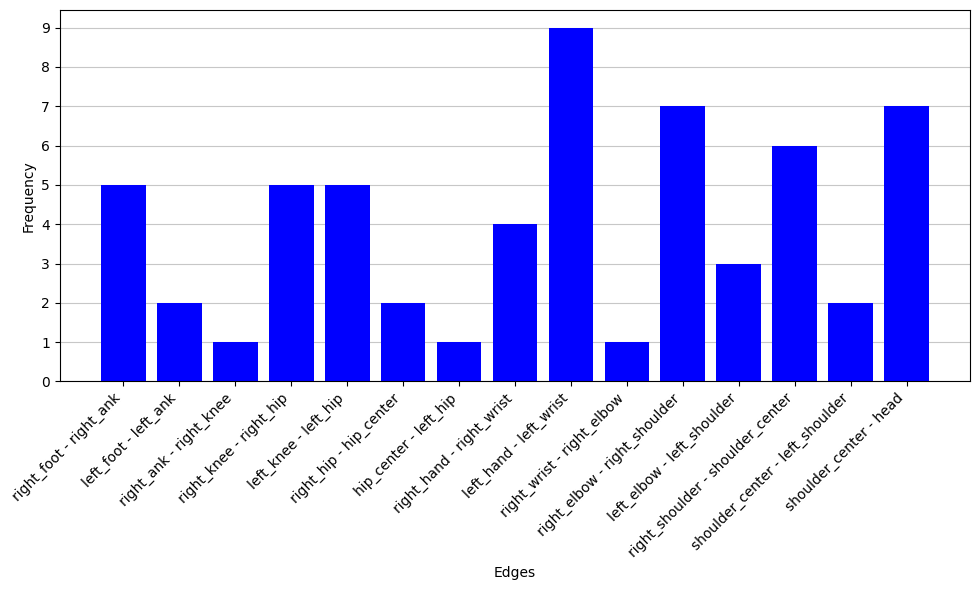

In [15]:
import matplotlib.pyplot as plt

physToIdx = {'left_foot':2,'right_foot':1,'left_ank':4,'right_ank':3,'left_knee':6,'right_knee':5,'left_hip':9,'hip_center':8,'right_hip':7,'spine':10,'left_hand':12,'right_hand':11,'left_wrist':14,'right_wrist':13,'left_elbow':16,'right_elbow':15,'left_shoulder':19,'shoulder_center':18,'right_shoulder':17,'head':20}
indxToPhys = {v: k for k, v in physToIdx.items()}

labels2 = list(results.keys())
x_labels = list(sorted(list(set(labels2))))

y_values = [results[label] for label in x_labels ]

average = sum(y_values) / len(y_values)

plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='-', axis='y',alpha=0.7)
#plt.axhline(average, color='blue', linestyle='--', zorder=0)
plt.bar(range(0,len(x_labels)), y_values, color='blue')
plt.xticks(range(0,len(x_labels)),[indxToPhys[i]+' - '+indxToPhys[j] for i,j in x_labels],rotation=45, ha='right')
plt.yticks(range(0,max(y_values)+1))
plt.xlabel('Edges')
plt.ylabel('Frequency')
#plt.title('Distribuzione joints dataset')

#plt.annotate(f'Media con annotazioni: {average:.2f}', xy=(6, average), xytext=(2,average+3),
#             arrowprops=dict(facecolor='blue', arrowstyle='->'), color='black')

plt.gca().set_axisbelow(True)
#plt.legend()
plt.tight_layout()

plt.show()

## Machine Learning

#### Metrics
- Confusion Matrix

| Actual \ Predicted | False | True |
|---------|-----------|------------|
| False |   TN      |     FP     |
| True  |   FN      |     TP     |

- Precision:
 TP / (TP + FP)

- Specificity:
 TN / (TN + FP)

- Recall:
 TP / (TP + FN)

- F1 Score:
 2 * Precision * Recall / (Precision + Recall)


### Definitive algorithm for binary classification

In [16]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import graphviz  # Make sure to install graphviz: pip install graphviz
from sklearn.tree import export_graphviz

def plot_tree(tree, columns):
    # Export the decision tree to DOT format
    dot_data = export_graphviz(tree, out_file=None,
                                feature_names=columns,
                                class_names=['Nope','Yes'],
                                rounded=True, special_characters=True)

    # Create a Graphviz object
    graph = graphviz.Source(dot_data, format='png')

    # Render the decision tree as a PNG file
    graph.render("loan_decision_tree")

    # Display the PNG using Matplotlib
    image = plt.imread("loan_decision_tree.png")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [17]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier

features = ...
labels = ...
top_features = {}
seed = None

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    if len(labels_count) < 2:
        return labels[i], 0.0
    ratio = 0.4
    m_neigh = np.clip(int(labels_count[0] * ratio), 1, len(train_labels)) # The nearest neighbors used to determine if a minority sample is in "danger"
    k_neigh = np.clip(int(labels_count[1] * ratio), 1, len(train_labels)) # The nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples.
    

    # Fit the model with different hyperparameters using BorderlineSMOTE
    train_features_resampled, train_labels_resampled = BorderlineSMOTE(k_neighbors=k_neigh, m_neighbors=m_neigh, random_state=seed).fit_resample(train_features, train_labels)

    rf = RandomForestClassifier(n_estimators=500,random_state=seed)
    rf.fit(train_features_resampled,train_labels_resampled)

    # Sort the indices based on importances in descending order
    top_indices = np.argsort(np.array(rf.feature_importances_))[::-1][:50]
    for indice in top_indices:
        if not indice in top_features.keys():
            top_features[indice] = 1
        else:
            top_features[indice] += 1

    train_important_features = train_features_resampled[:, top_indices]
    test_important_features = features[i, top_indices].reshape(1, -1)

    rf = RandomForestClassifier(n_estimators=200, max_features=None,random_state=seed)
    rf.fit(train_important_features, train_labels_resampled)
    #if i==0:
    #    plot_tree(rf.estimators_[1], [list(dataset.columns)[i] for i in top_indices])

    # Predict on the test instance
    rf_prediction = rf.predict_proba(test_important_features)

    return labels[i], rf_prediction[0][1]

### Question 1: "To be edge or not to be edge? That is the question"

In [4]:
import pandas as pd
import os

ANNOTATIONS_PATH = 'data'
dataset = pd.read_csv(os.path.join(ANNOTATIONS_PATH,'Dataset.csv'))

#### Final version

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import numpy as np


target_label = list(dataset['OoM'].value_counts().index)[0]
question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
print(question)
labels = np.array((dataset['OoM'] == target_label).astype(int))
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []
seed = None#42
top_features = {}

if seed is None and False:
    for _ in tqdm(range(2),desc="Double execution progression:"):
        # Create a ThreadPoolExecutor (use ProcessPoolExecutor for processes)
        with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results_per_iter.append(list(tqdm(executor.map(train_and_predict, range(-n)), total=n, desc="LOOCV: ",leave=False)))

    consistent_results = True
    for i in range(n):
        if tuple(map(round, results_per_iter[0][i])) != tuple(map(round, results_per_iter[1][i])):
            consistent_results = False
            print("\033[91mExecutions not consistent!\033[0m")
            break
    if consistent_results:
        print("\033[92mExecutions are consistent!\033[0m")

    results = results_per_iter[0]
else:
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

#print(list(sorted(top_features.items(), key=lambda item: item[1],reverse=True)))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Is (12, 14)?


LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

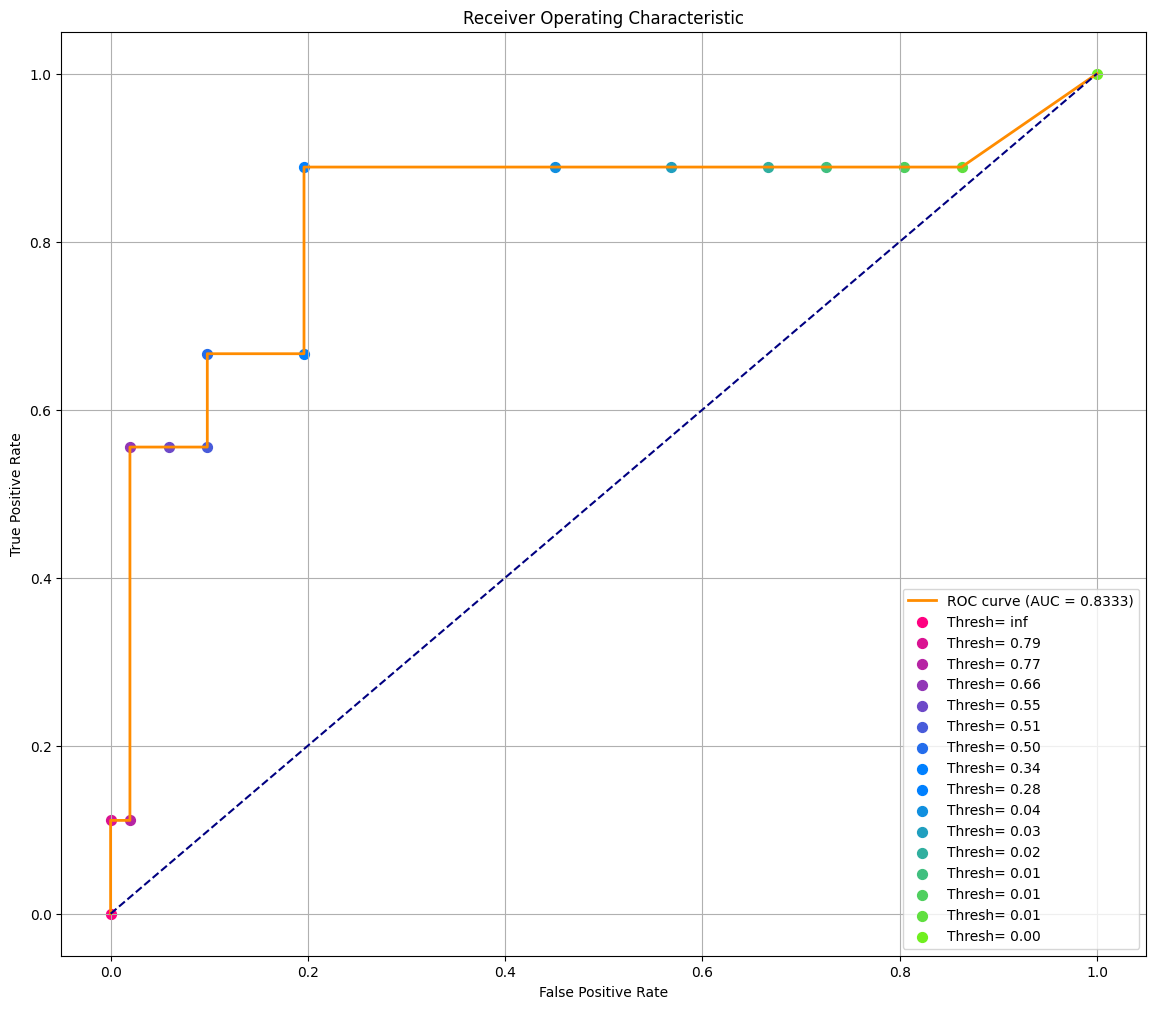

In [61]:
# Plot ROC curve
plt.figure(figsize=(14,12))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Plot classification threshold markers
import numpy as np

# Define the starting and ending colors as RGB tuples
start_color = (255, 0, 128)  # Red
intermediary_color = ( 0, 128, 255)  # Blue
end_color = (128, 255, 0)    # Green

# Number of colors to generate (including the endpoints)
n_colors = len(thresholds)

# Create a list of RGB colors along the linear gradient
colors = []
for i in range(n_colors):
    # Interpolate RGB values linearly between start and end colors
    r = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[0], intermediary_color[0]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[0], end_color[0]], left=0))
    g = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[1], intermediary_color[1]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[1], end_color[1]], left=0))
    b = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[2], intermediary_color[2]], right=0) + 
        np.interp(i, [n_colors // 2, n_colors], [intermediary_color[2], end_color[2]], left=0))
    colors.append(f'#{r:02X}{g:02X}{b:02X}')

for index, thresh in enumerate(thresholds):
    plt.scatter(fpr[index], tpr[index], marker='o', color=colors[index], label=f'Thresh= {thresholds[index]:.2f}', s=50, zorder=0)

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

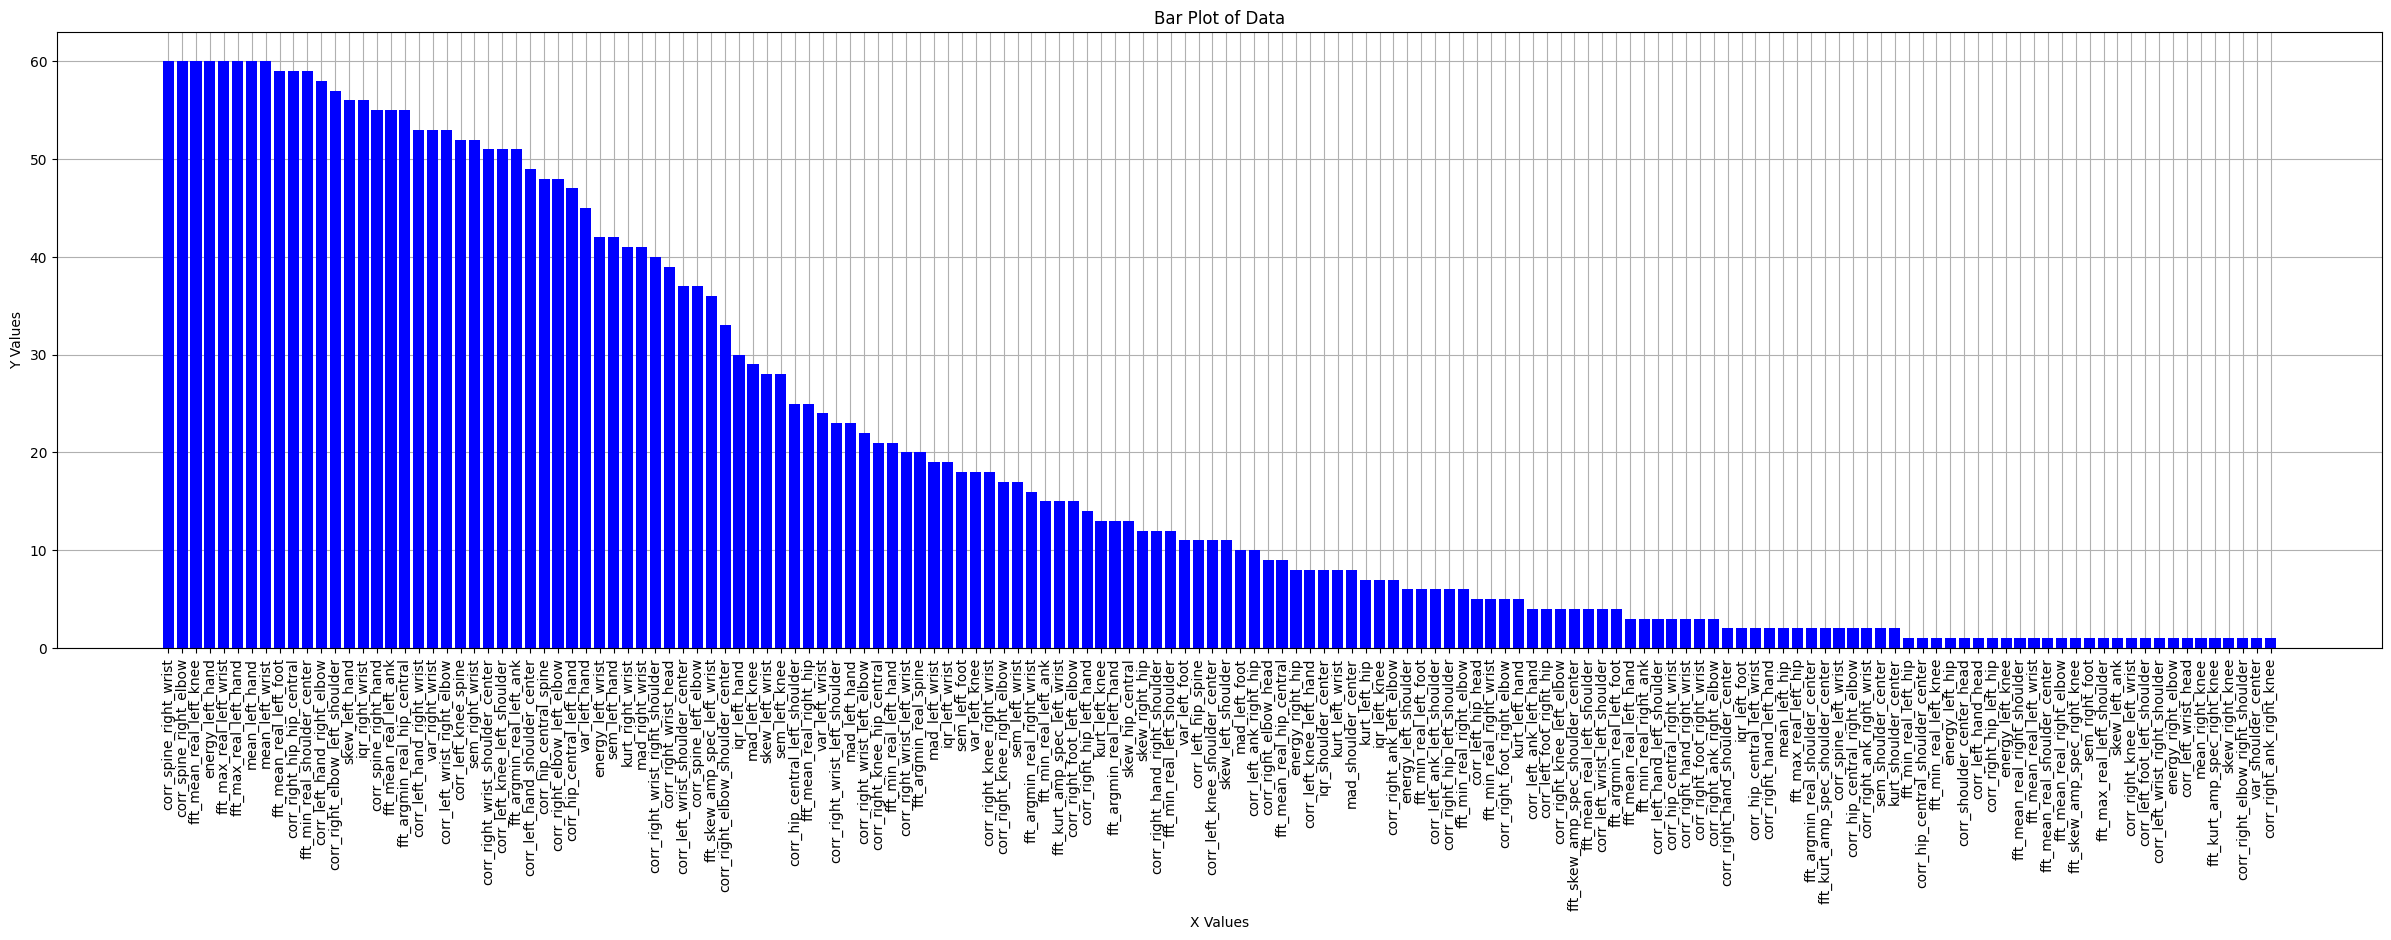

In [62]:
top_features = list(sorted(top_features.items(), key=lambda item: item[1],reverse=True))
#pd.Series(top_features)
import matplotlib.pyplot as plt
# Separate the data into x and y values
x_values, y_values = zip(*top_features)
x_values = [list(dataset.columns)[x] for x in x_values]

# Create a bar plot
fig, ax = plt.subplots(figsize=(30, 8))
bars = plt.bar(x_values, y_values, color='blue')

# Rotate x-labels to make them vertical
plt.xticks(rotation=90)  # Adjust the rotation angle as needed

# Add labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Bar Plot of Data')
plt.grid()
ax.set_axisbelow(True)

# Show the plot
plt.show()

#### Plotting juicy features

In [63]:
physToIdx = {'Lfoot':2,'Rfoot':1,'Lank':4,'Rank':3,'Lknee':6,'Rknee':5,'Lhip':9,'Chip':8,'Rhip':7,'spine':10,'Lhand':12,'Rhand':11,'Lwrist':14,'Rwrist':13,'Lelbow':16,'Relbow':15,'Lshoulder':19,'Cshoulder':18,'Rshoulder':17,'head':20}
indxToPhys = {v: k for k, v in physToIdx.items()}
def map_pos_human_body_graph():
    physToIdx = {'Lfoot':2,'Rfoot':1,'Lank':4,'Rank':3,'Lknee':6,'Rknee':5,'Lhip':9,'Chip':8,'Rhip':7,'spine':10,'Lhand':12,'Rhand':11,'Lwrist':14,'Rwrist':13,'Lelbow':16,'Relbow':15,'Lshoulder':19,'Cshoulder':18,'Rshoulder':17,'head':20}
    return {
        physToIdx['head']: [0,1],
        physToIdx['Cshoulder']: [0,0.75],
        physToIdx['Rshoulder']: [-0.55,0.65],
        physToIdx['Lshoulder']: [0.55,0.65],
        physToIdx['Relbow']: [-0.70,0.35],
        physToIdx['Lelbow']: [0.70,0.35],
        physToIdx['Rwrist']: [-0.80,0],
        physToIdx['Lwrist']: [0.80,0],
        physToIdx['Rhand']: [-1,-0.15],
        physToIdx['Lhand']: [1,-0.15],
        physToIdx['spine']: [0,0.25],
        physToIdx['Chip']: [0,0],
        physToIdx['Rhip']: [-0.4,-0.2],
        physToIdx['Lhip']: [0.4,-0.2],
        physToIdx['Rknee']: [-0.45,-0.55],
        physToIdx['Lknee']: [0.45,-0.55],
        physToIdx['Rank']: [-0.5,-0.85],
        physToIdx['Lank']: [0.5,-0.85],
        physToIdx['Rfoot']: [-0.78,-1],
        physToIdx['Lfoot']: [0.78,-1]
    }
physToIdx = {key.replace('L','left_').replace('R','right_').replace('Chip','hip_central').replace('Cshoulder','shoulder_center'): value for key,value in physToIdx.items()}
indxToPhys = {v: k for k, v in physToIdx.items()}

[  1 110   3 122   4 157  45  77  13  20   0 418 264 329   8   0   1  89
  34   0]


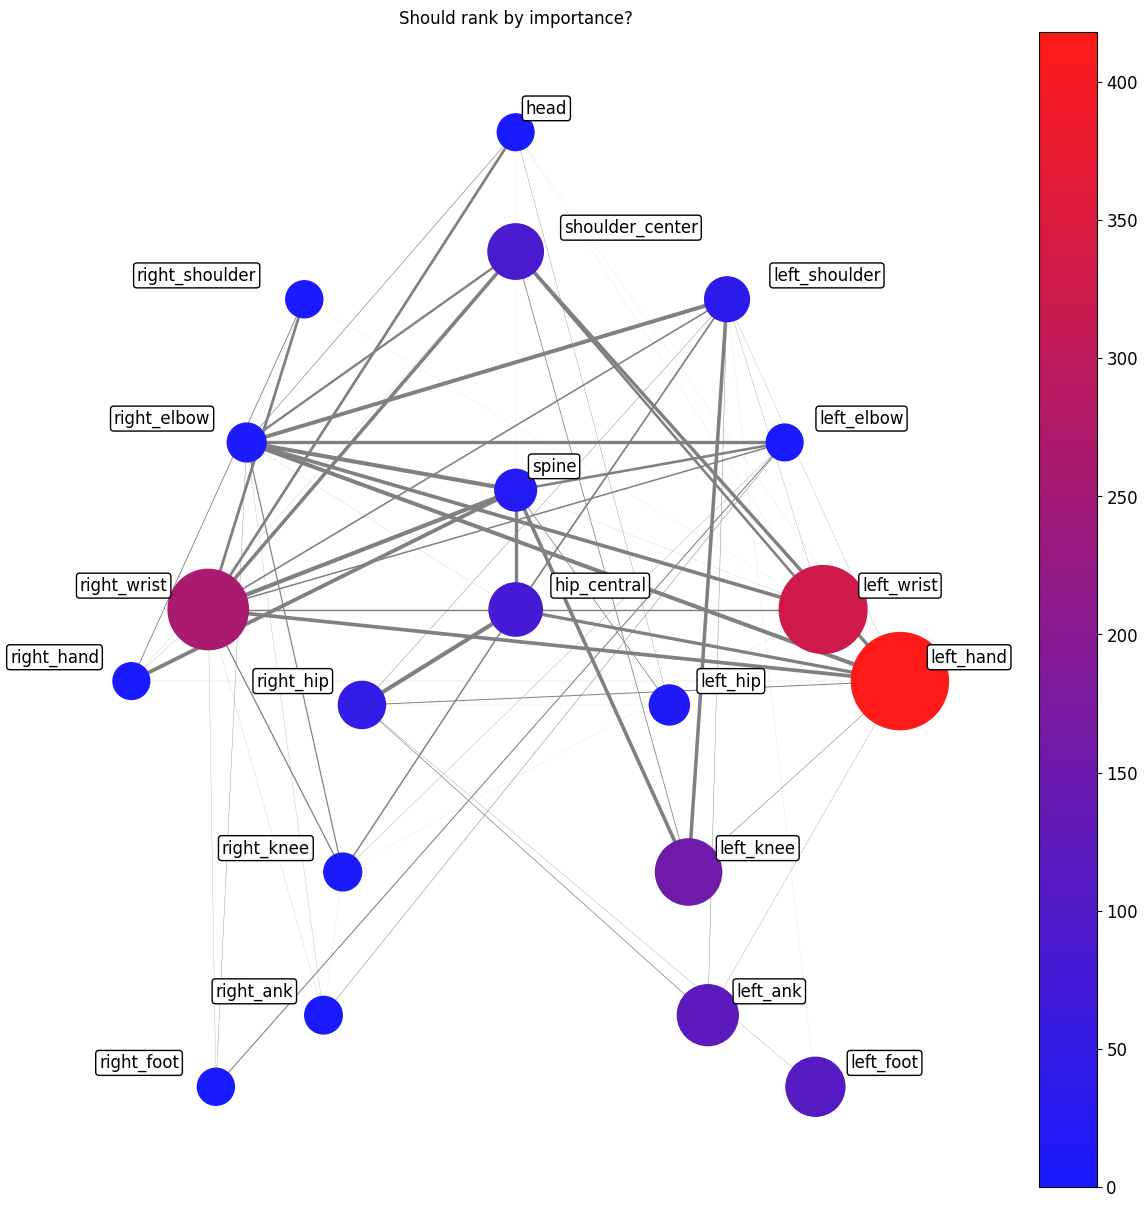

In [64]:
import networkx as nx
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),int)
#adjacencyMatrix[edges[:,0],edges[:,1]] = True

nodes_counts = np.zeros(len(allNodes),dtype=int)
for i,feature_name in enumerate(x_values):
    if not 'corr' in feature_name:
        for node_name in physToIdx.keys():
            if node_name in feature_name:
               nodes_counts[physToIdx[node_name]-1] += y_values[i]
               break
    else:
        node1 = None
        for node_name in physToIdx.keys():
            if node_name in feature_name:
                node1 = physToIdx[node_name]-1
        node2 = None
        for node_name in physToIdx.keys():
            if node_name in feature_name and node_name != indxToPhys[node1+1]:
                node2 = physToIdx[node_name]-1
        adjacencyMatrix[node1,node2] += y_values[i]
        adjacencyMatrix[node2,node1] += y_values[i]
#print(adjacencyMatrix)
nodes_sizes = [700 + 10*nodes_counts[i] for i in range(20)]

normalized_values = (nodes_counts - min(nodes_counts)) / (max(nodes_counts) - min(nodes_counts))
print(nodes_counts)

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(adjacencyMatrix)
graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

pos = map_pos_human_body_graph()

fig, ax = plt.subplots(figsize=(15,15))
cmap = LinearSegmentedColormap.from_list('BlueToRed', [(0.1,0.1,1), (1,0.1,0.1)], N=256)

nx.draw(graph, pos, with_labels=False,node_size=nodes_sizes, node_color=normalized_values, edge_color="gray",cmap=cmap, width=[graph[u][v]['weight']/20 for u,v in graph.edges()])

plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(nodes_counts), vmax=max(nodes_counts))),ax=ax).ax.tick_params(labelsize=12)

# Add annotations for joint names
for node, (x, y) in pos.items():
    plt.text(x+(np.sign(x) or True)*len(indxToPhys[node])*0.02, y+0.05, indxToPhys[node], fontsize=12,ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
plt.title("Should rank by importance?")
plt.show()

[ 1  7  1  4  4  8  3  3  5  1  0 12  7 12  3  0  1 10  5  0]


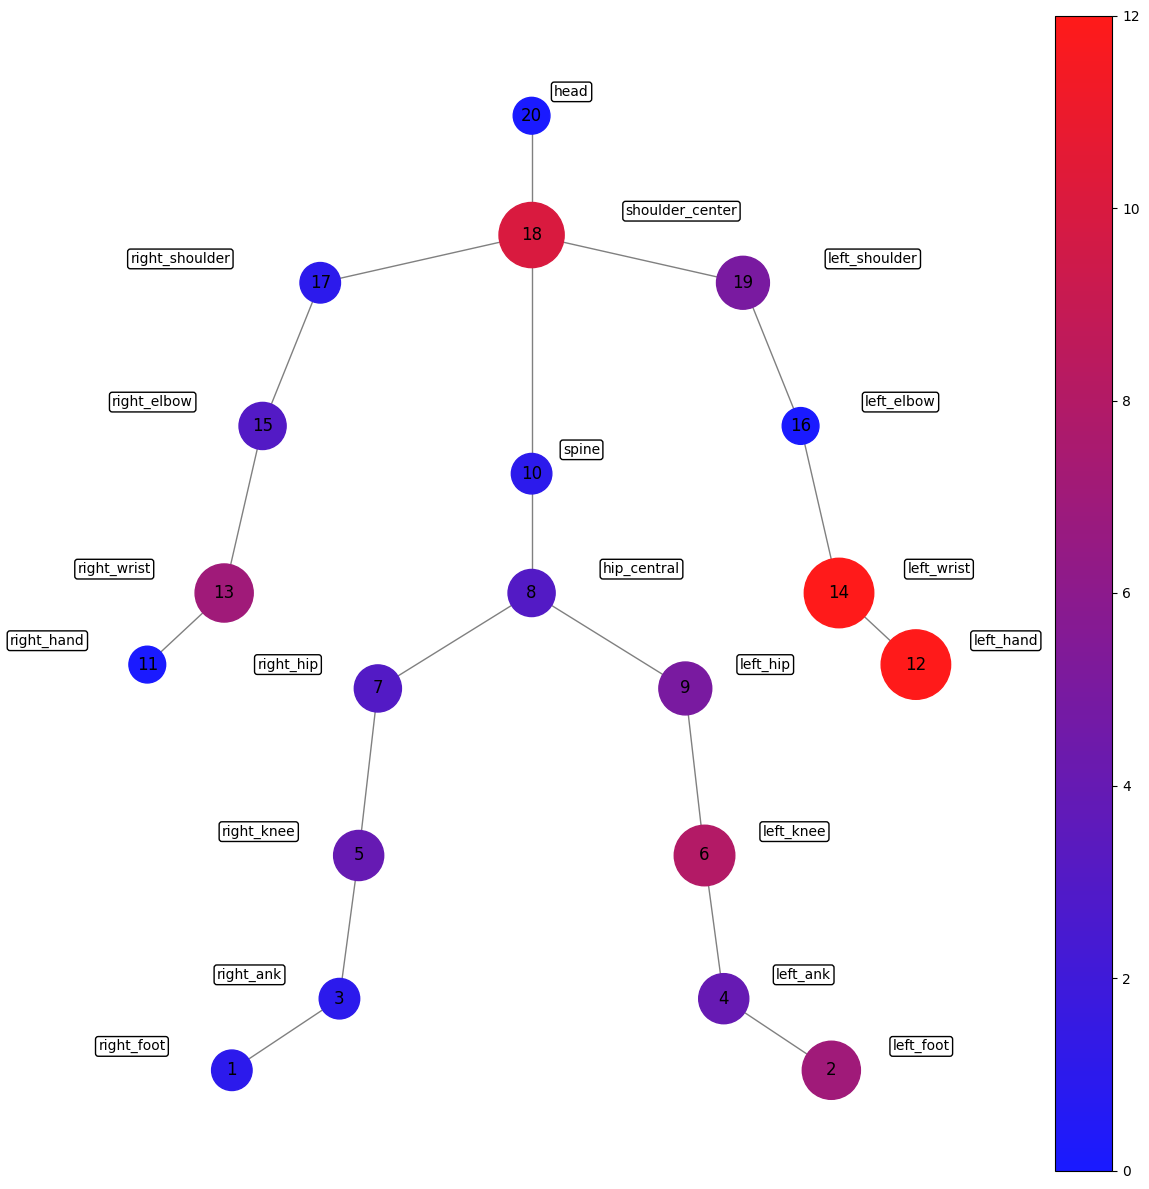

In [65]:
import networkx as nx
import matplotlib.cm as cm
import matplotlib as mtplt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

nodes_counts = np.zeros(20,dtype=int)
for feature_name in x_values:
    if not 'corr' in feature_name:
        for node_name in physToIdx.keys():
            if node_name in feature_name:
               nodes_counts[physToIdx[node_name]-1] += 1 

nodes_sizes = [700 + 150*nodes_counts[i] for i in range(20)]

normalized_values = (nodes_counts - min(nodes_counts)) / (max(nodes_counts) - min(nodes_counts))
print(nodes_counts)

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(adjacencyMatrix)
graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

pos = map_pos_human_body_graph()

fig, ax = plt.subplots(figsize=(15,15))
cmap = LinearSegmentedColormap.from_list('BlueToRed', [(0.1,0.1,1), (1,0.1,0.1)], N=256)
nx.draw(graph, pos, with_labels=True,node_size=nodes_sizes, node_color=normalized_values, edge_color="gray",cmap=cmap)
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(nodes_counts), vmax=max(nodes_counts)))

plt.colorbar(sm,ax=ax)


# Add annotations for joint names
for node, (x, y) in pos.items():
    plt.text(x+(np.sign(x) or True)*len(indxToPhys[node])*0.026, y+0.05, indxToPhys[node], fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

plt.show()

#### Testing Overall Performances

In [14]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

n = len(dataset)
label_occurences_sorted = list(dataset['OoM'].value_counts().index)
total_score = 0
avg_accuracy = 0
conf_mats = {}
seed = 12
for i in tqdm(range(len(label_occurences_sorted)), 'Testing every label'):
    target_label = label_occurences_sorted[i]
    question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
    #print(question)
    labels = np.array((dataset['OoM'] == target_label).astype(int))
    features = np.array(dataset.drop('OoM',axis=1))

    with multiprocessing.Pool(processes=4) as executor:
        results = list(tqdm(executor.imap(train_and_predict, range(n)), total=n, desc="LOOCV: ",leave=False))

    y_true, y_score = zip(*results)

    avg_accuracy += accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

    confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
    conf_mats[str(ord_to_OoM[int(target_label)])] = confusion_mat
    total_score += confusion_mat[1][1]

#print(total_score/len(dataset))
print(avg_accuracy/len(label_occurences_sorted))
for key in conf_mats.keys():
    print(conf_mats[key])

Testing every label:   0%|          | 0/15 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

0.9133333333333332
[[48  3]
 [ 3  6]]
[[51  2]
 [ 6  1]]
[[44  9]
 [ 7  0]]
[[51  3]
 [ 4  2]]
[[52  3]
 [ 4  1]]
[[50  5]
 [ 5  0]]
[[53  2]
 [ 2  3]]
[[54  2]
 [ 4  0]]
[[57  0]
 [ 3  0]]
[[56  2]
 [ 2  0]]
[[58  0]
 [ 2  0]]
[[58  0]
 [ 2  0]]
[[59  0]
 [ 1  0]]
[[59  0]
 [ 1  0]]
[[59  0]
 [ 1  0]]


In [19]:
avg_accuracy = 0
avg_f1 = 0
for key in conf_mats.keys():
    recall = (conf_mats[key][1,1])/(conf_mats[key][1,1]+conf_mats[key][1,0])
    accuracy = (conf_mats[key][1,1]+conf_mats[key][0,0])/(np.sum(conf_mats[key], axis=None))
    print(key, '\t', recall, '\t\t\t', accuracy)

(12, 14) 	 0.6666666666666666 			 0.9
(18, 20) 	 0.14285714285714285 			 0.8666666666666667
(15, 17) 	 0.0 			 0.7333333333333333
(17, 18) 	 0.3333333333333333 			 0.8833333333333333
(5, 7) 	 0.2 			 0.8833333333333333
(1, 3) 	 0.0 			 0.8333333333333334
(6, 9) 	 0.6 			 0.9333333333333333
(11, 13) 	 0.0 			 0.9
(16, 19) 	 0.0 			 0.95
(7, 8) 	 0.0 			 0.9333333333333333
(18, 19) 	 0.0 			 0.9666666666666667
(2, 4) 	 0.0 			 0.9666666666666667
(3, 5) 	 0.0 			 0.9833333333333333
(8, 9) 	 0.0 			 0.9833333333333333
(13, 15) 	 0.0 			 0.9833333333333333


#### Testing Consistency

In [532]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier


target_label = list(dataset['OoM'].value_counts().index)[0]
question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
print(question)
labels = np.array((dataset['OoM'] == target_label).astype(int))
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []
seed = None#42

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    ratio = 0.4
    m_neigh = np.clip(int(labels_count[0] * ratio), 1, len(train_labels)) # The nearest neighbors used to determine if a minority sample is in "danger"
    k_neigh = np.clip(int(labels_count[1] * ratio), 1, len(train_labels)) # The nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples.
    

    # Fit the model with different hyperparameters using BorderlineSMOTE
    train_features_resampled, train_labels_resampled = BorderlineSMOTE(k_neighbors=k_neigh, m_neighbors=m_neigh, random_state=seed).fit_resample(train_features, train_labels)

    rf = RandomForestClassifier(n_estimators=500,random_state=seed)
    rf.fit(train_features_resampled,train_labels_resampled)

    # Sort the indices based on importances in descending order
    top_indices = np.argsort(np.array(rf.feature_importances_))[::-1][:50]

    train_important_features = train_features_resampled[:, top_indices]
    test_important_features = features[i, top_indices].reshape(1, -1)

    rf = RandomForestClassifier(n_estimators=200, max_features=None,random_state=seed)
    rf.fit(train_important_features, train_labels_resampled)

    # Predict on the test instance
    rf_prediction = rf.predict_proba(test_important_features)

    return labels[i], rf_prediction[0][1]

# Number of iterations (n)
n = len(features)
results_per_iter = []

if seed is None:
    for _ in tqdm(range(2),desc="Double execution progression:"):
        # Create a ThreadPoolExecutor (use ProcessPoolExecutor for processes)
        with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results_per_iter.append(list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: ",leave=False)))

    consistent_results = True
    for i in range(n):
        if tuple(map(round, results_per_iter[0][i])) != tuple(map(round, results_per_iter[1][i])):
            consistent_results = False
            print("\033[91mExecutions not consistent!\033[0m")
            break
    if consistent_results:
        print("\033[92mExecutions are consistent!\033[0m")

    results = results_per_iter[0]
else:
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
            results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Is (12, 14)?


Double execution progression::   0%|          | 0/2 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

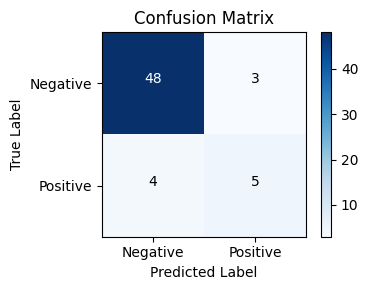

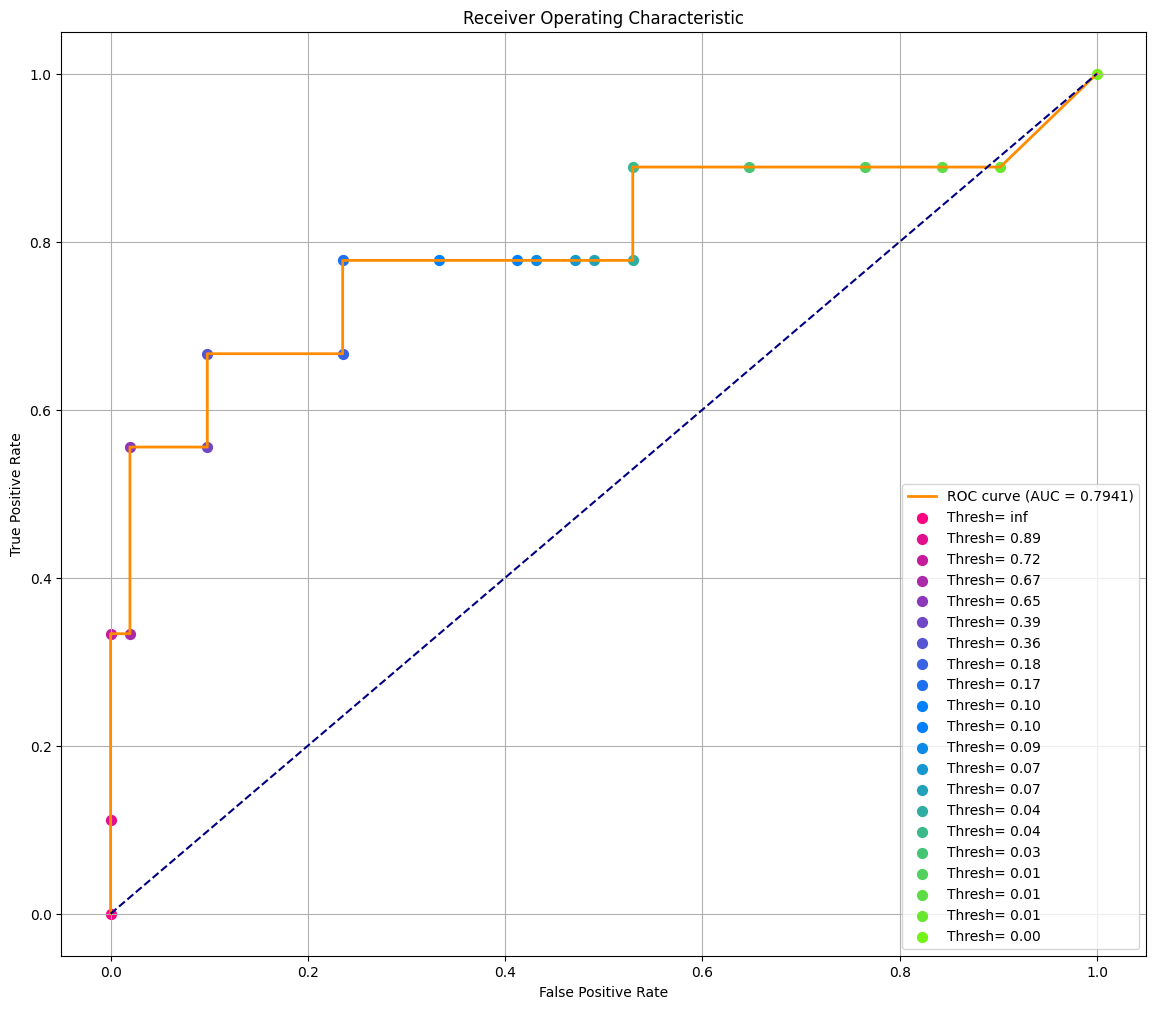

In [12]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
results = results_per_iter[1]

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

fpr, tpr, thresholds = roc_curve(y_true, (np.array(y_score) > 0.27).astype(int))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(14,12))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Plot classification threshold markers
import numpy as np

# Define the starting and ending colors as RGB tuples
start_color = (255, 0, 128)  # Red
intermediary_color = ( 0, 128, 255)  # Blue
end_color = (128, 255, 0)    # Green

# Number of colors to generate (including the endpoints)
n_colors = len(thresholds)

# Create a list of RGB colors along the linear gradient
colors = []
for i in range(n_colors):
    # Interpolate RGB values linearly between start and end colors
    r = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[0], intermediary_color[0]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[0], end_color[0]], left=0))
    g = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[1], intermediary_color[1]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[1], end_color[1]], left=0))
    b = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[2], intermediary_color[2]], right=0) + 
        np.interp(i, [n_colors // 2, n_colors], [intermediary_color[2], end_color[2]], left=0))
    colors.append(f'#{r:02X}{g:02X}{b:02X}')

for index, thresh in enumerate(thresholds):
    plt.scatter(fpr[index], tpr[index], marker='o', color=colors[index], label=f'Thresh= {thresholds[index]:.2f}', s=50, zorder=0)

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


#### Trials for optimal algorithm

##### Balanced class weight & RandomSearch hyperparam tuning & sensitivity as score

In [20]:
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import LeaveOneOut
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, recall_score, precision_score
from tqdm.notebook import tqdm

target_label = list(dataset['OoM'].value_counts().index)[0]
question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
print(question)
dataset[question] = dataset['OoM'] == target_label
labels = np.array(dataset[question].astype(int))
features = np.array(dataset.drop('OoM',axis=1).drop(question,axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []

# Define a parameter distribution to sample from
param_dist = {
    'n_estimators': randint(10, 400),
    #'max_depth': randint(2, 10),
    #'min_samples_split': randint(2, 5)
}

rf = RandomForestClassifier(n_jobs=-1,random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1, scoring=make_scorer(accuracy_score))

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 300]
}

# Create a GridSearchCV object
grid_search = GridSearchCV( estimator=rf, param_grid=param_grid, cv=LeaveOneOut(), scoring=make_scorer(accuracy_score), n_jobs=-1)

sampler = RandomUnderSampler(random_state=42)

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    
    t,s = sampler.fit_resample(train_features, train_labels)
    #print(len(s))
    # Fit the model with different hyperparameters
    #random_search.fit(train_features,train_labels)
    grid_search.fit(t,s)
    #print(pd.DataFrame(grid_search.cv_results_))
    rf = grid_search.best_estimator_
    
    # Train the model on training data
    #rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])
    cm = confusion_matrix(y_class_true,y_class_pred,labels=[0,1])
    #print(f"TN:{cm[0,0]} FP:{cm[0,1]} FN:{cm[1,0]} TP:{cm[1,1]}",end='\r')

# Print confusion matrix and accuracy
print("Confusion Matrix:       ")
print(confusion_matrix(y_class_true, y_class_pred))
y_true = y_class_true
y_pred = y_class_pred
print(accuracy_score(y_true,y_pred), recall_score(y_true,y_pred), precision_score(y_true,y_pred))

Is (12, 14)?


  0%|          | 0/60 [00:00<?, ?it/s]

Confusion Matrix:       
[[41 10]
 [ 2  7]]
0.8 0.7777777777777778 0.4117647058823529


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
y_true = y_class_true
y_pred = y_class_pred
cm = confusion_matrix(y_true,y_pred,labels=[0,1])
print(cm)
print(accuracy_score(y_true,y_pred), recall_score(y_true,y_pred), precision_score(y_true,y_pred))

[[40 11]
 [ 3  6]]
0.7666666666666667 0.6666666666666666 0.35294117647058826


##### Balanced class weight

In [21]:
rf = RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample',n_jobs=-1)
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])
    
y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))

  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 9  0]]


##### Oversampling

In [23]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


rf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
ros = RandomOverSampler()
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ros.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))

  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 8  1]]


##### Undersampling

In [534]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


rf = RandomForestClassifier(n_jobs=-1, n_estimators = 500)
ruc = RandomUnderSampler(replacement=True)
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ruc.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)

  0%|          | 0/60 [00:00<?, ?it/s]

[[41 10]
 [ 2  7]]


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

rf = RandomForestClassifier(n_estimators=3000)
ruc = RandomUnderSampler()
n = len(labels)
y_true = []
y_scores = []

# Define a function for model training and prediction
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ruc.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)

    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)  # Get prediction probabilities

    return test_labels, rf_prediction[0]

# Create a ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n))


y_true = np.array(y_true)
y_scores = np.array(y_scores)
print(confusion_matrix(y_true,y_pred))
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


  0%|          | 0/60 [00:00<?, ?it/s]

/home/gagg/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:882: RuntimeWarning: divide by zero encountered in divide
  proba /= len(self.estimators_)


AttributeError: 'list' object has no attribute 'take'

##### SMOTE

In [24]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE()

n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)

  0%|          | 0/60 [00:00<?, ?it/s]

[[50  1]
 [ 6  3]]


##### Borderline-SMOTE

In [29]:
from imblearn.over_sampling import BorderlineSMOTE

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
# Create an instance of Borderline-SMOTE
borderline_smote = BorderlineSMOTE()
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = borderline_smote.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)


  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 8  1]]


In [539]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor  # Use ThreadPoolExecutor or ProcessPoolExecutor
from sklearn.metrics import confusion_matrix

# Define a function to perform the model training and prediction for one iteration
def train_and_predict(i):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    labels_count = np.bincount(train_labels)
    ratio = len(train_labels)//1.3
    m_neigh = np.clip(int(labels_count[0]/len(train_labels)*ratio),1,len(train_labels))
    k_neigh = np.clip(int(labels_count[1]/len(train_labels)*ratio),1,len(train_labels))

    # Fit the model with different hyperparameters using BorderlineSMOTE
    sampler = BorderlineSMOTE(k_neighbors=k_neigh,m_neighbors=m_neigh)    
    
    rf = RandomForestClassifier(n_estimators= 1000)
    rf.fit(*sampler.fit_resample(train_features, train_labels))

    # Get numerical feature importances
    #importances = list(rf.feature_importances_)
    #importances_array = np.array(importances)
    #indices_above_threshold = np.where(importances_array > 0.1)[0]  # Get the indices
    #importances_above_threshold = importances_array[importances_array > 0.1]  #

    # Sort the feature importances by most important first
    #feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Predict on the test instance
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)

    return test_labels, rf_prediction[0]

# Number of iterations (n)
n = len(features)

# Create a ThreadPoolExecutor (use ProcessPoolExecutor for processes)
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n))

# Separate the true labels and predicted labels from the results
y_class_true, y_class_pred = zip(*results)

print(confusion_matrix(y_class_true, y_class_pred, labels=[0, 1]))

  0%|          | 0/60 [00:00<?, ?it/s]

[[50  1]
 [ 7  2]]


In [ ]:
# loocv to automatically evaluate the performance of a random forest classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE

# Create an instance of Borderline-SMOTE
borderline_smote = BorderlineSMOTE(k_neighbors=1,m_neighbors=5)
features_resampled, labels_resampled = borderline_smote.fit_resample(features, labels)
print(borderline_smote.get_params())

# create model
rf = RandomForestClassifier(n_estimators=300)
# Define a parameter grid to search over
param_grid = {
    'n_estimators': list(range(100,700,50))
}

# Create a GridSearchCV object
grid_search = GridSearchCV( estimator=rf, param_grid=param_grid, scoring=make_scorer(accuracy_score), n_jobs=-1)
# evaluate model
predictions = cross_val_predict(rf, features_resampled, labels_resampled, cv=LeaveOneOut(), n_jobs=-1,verbose=1)
# report performance
print('Conf mat:\n', confusion_matrix(labels_resampled,predictions))

{'k_neighbors': 1, 'kind': 'borderline-1', 'm_neighbors': 5, 'n_jobs': None, 'random_state': None, 'sampling_strategy': 'auto'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s


Conf mat:
 [[50  1]
 [ 1 50]]


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   17.7s finished


##### Adasyn

In [ ]:
from imblearn.over_sampling import ADASYN

rf = RandomForestClassifier(n_jobs=-1)
# Create an instance of adasyn
adasyn = ADASYN(sampling_strategy='auto')
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = adasyn.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)


  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 5  4]]


### Question 2: "Top or Bottom?"
Same alg than before

In [30]:
ANNOTATIONS_PATH = 'data'
dataset = pd.read_csv(os.path.join(ANNOTATIONS_PATH,'Dataset.csv'))

[]

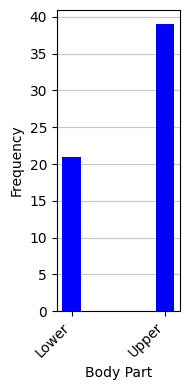

In [62]:
import matplotlib.pyplot as plt
from collections import Counter

ord_edge_groups = {0: [0,1,2,3,4,5,6], 1:[7,8,9,10,11,12,13,14]}
group_names = {0: "Lower", 1: "Upper"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}

labels = np.array(dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])).astype(int)
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)

x_labels = list(sorted(list(set(labels))))

y_values = [count for value,count in sorted(Counter(labels).items())]


plt.figure(figsize=(2, 4))
plt.grid(True, linestyle='-', axis='y',alpha=0.7)
#plt.axhline(average, color='blue', linestyle='--', zorder=0)
plt.bar(range(0,len(x_labels)), y_values, color='blue',width=0.2)
plt.xticks(range(0,len(x_labels)),group_names.values(),rotation=45, ha='right')

plt.xlabel('Body Part')
plt.ylabel('Frequency')
#plt.title('Distribuzione joints dataset')

#plt.annotate(f'Media con annotazioni: {average:.2f}', xy=(6, average), xytext=(2,average+3),
#             arrowprops=dict(facecolor='blue', arrowstyle='->'), color='black')

plt.gca().set_axisbelow(True)
#plt.legend()
plt.tight_layout()
plt.show()

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

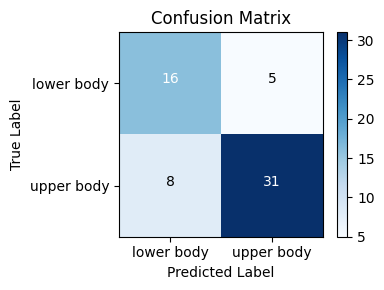

Accuracy:  0.7833333333333333


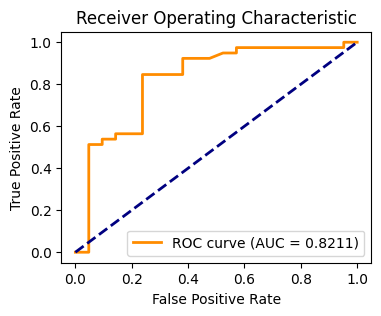

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import numpy as np

top_features = {}
seed = 12

with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = [group_names[0], group_names[1]]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

0.75


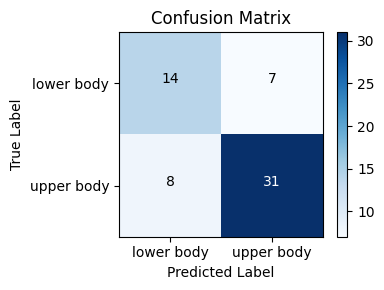

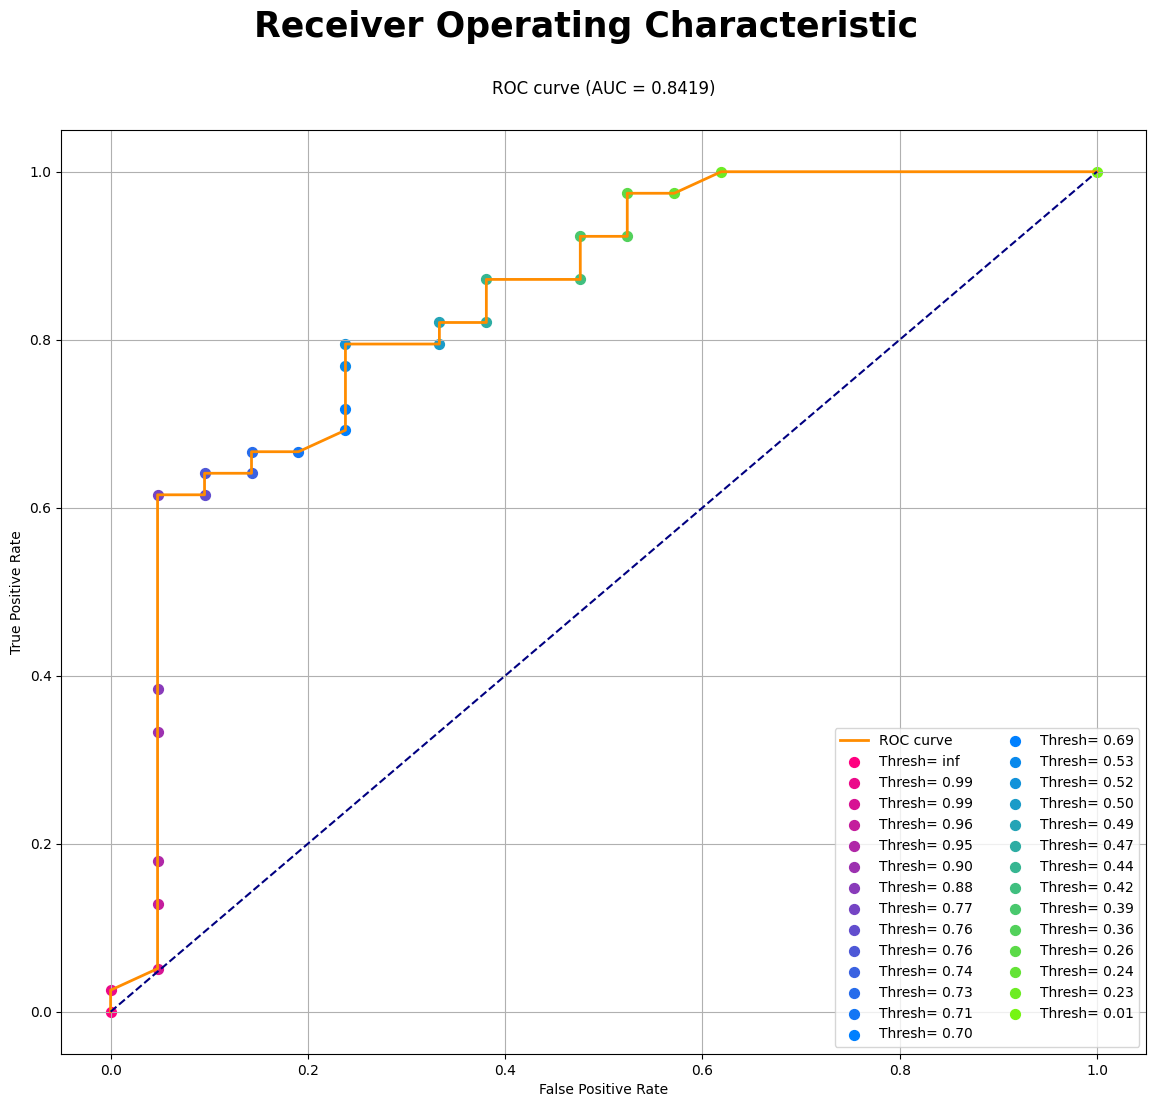

In [17]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
results = results_per_iter[1]

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = [group_names[0], group_names[1]]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
print(accuracy)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(14,12))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')

# Plot classification threshold markers
import numpy as np

# Define the starting and ending colors as RGB tuples
start_color = (255, 0, 128)  # Red
intermediary_color = ( 0, 128, 255)  # Blue
end_color = (128, 255, 0)    # Green

# Number of colors to generate (including the endpoints)
n_colors = len(thresholds)

# Create a list of RGB colors along the linear gradient
colors = []
for i in range(n_colors):
    # Interpolate RGB values linearly between start and end colors
    r = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[0], intermediary_color[0]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[0], end_color[0]], left=0))
    g = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[1], intermediary_color[1]], right=0) + 
            np.interp(i, [n_colors // 2, n_colors], [intermediary_color[1], end_color[1]], left=0))
    b = int(np.interp(i, [0, n_colors // 2 - 1], [start_color[2], intermediary_color[2]], right=0) + 
        np.interp(i, [n_colors // 2, n_colors], [intermediary_color[2], end_color[2]], left=0))
    colors.append(f'#{r:02X}{g:02X}{b:02X}')

for index, thresh in enumerate(thresholds):
    plt.scatter(fpr[index], tpr[index], marker='o', color=colors[index], label=f'Thresh= {thresholds[index]:.2f}', s=50, zorder=0)
    # Display the label next to the marker
    #plt.text(fpr[index]-0.1, tpr[index]+0.1, f'Thresh={thresholds[index]:.2f}', fontsize=10, va='center', ha='left')

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC = {roc_auc:.4f})',y=1.03)
plt.suptitle('Receiver Operating Characteristic', fontweight='bold',fontsize=25)
plt.legend(loc='lower right', ncols=2)
plt.show()


### Question 3: "My face is here, whatcha u looking at?"

In [2]:
import pandas as pd
import os

ANNOTATIONS_PATH = 'data'
dataset = pd.read_csv(os.path.join(ANNOTATIONS_PATH,'Dataset.csv'))

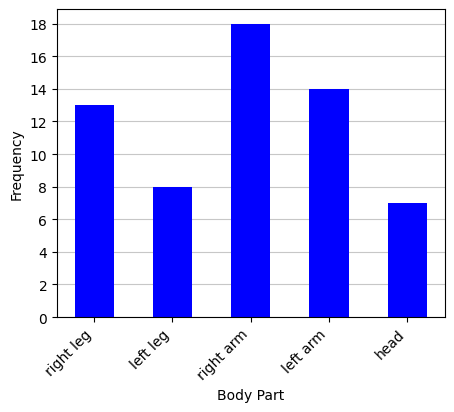

In [30]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

ord_edge_groups = {0: [0,2,3,5], 1:[1,4,6], 2:[7,9,10,12], 3:[8,11,13], 4:[14]}
group_names = {0: "right leg", 1: "left leg", 2:"right arm", 3:"left arm", 4:"head"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}

labels = np.array(dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])).astype(int)
features = np.array(dataset.drop('OoM',axis=1))

x_labels = list(sorted(list(set(labels))))

y_values = [count for _,count in sorted(Counter(labels).items())]
#print(y_values)

plt.figure(figsize=(5, 4))
plt.grid(True, linestyle='-', axis='y',alpha=0.7)
#plt.axhline(average, color='blue', linestyle='--', zorder=0)
plt.bar(range(0,len(x_labels)), y_values, color='blue',width=0.5)
plt.xticks(range(0,len(x_labels)),group_names.values(),rotation=45, ha='right')
plt.yticks(range(0,max(y_values)+1,2))
plt.xlabel('Body Part')
plt.ylabel('Frequency')

#plt.title('Distribuzione joints dataset')

#plt.annotate(f'Media con annotazioni: {average:.2f}', xy=(6, average), xytext=(2,average+3),
#             arrowprops=dict(facecolor='blue', arrowstyle='->'), color='black')

plt.gca().set_axisbelow(True)
#plt.legend()
#plt.tight_layout()
plt.show()

In [25]:
import multiprocessing
from tqdm.notebook import tqdm
import multiprocessing
from sklearn.metrics import accuracy_score, confusion_matrix

n = len(dataset)
label_occurences_sorted = list(dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label]).value_counts().index)
total_score = 0
avg_accuracy = 0
conf_mats = {}
top_features = {}
seed = 12
for i in tqdm(range(len(label_occurences_sorted)), 'Testing every body part'):
    target_label = label_occurences_sorted[i]
    labels = np.array((dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label]) == target_label).astype(int))
    features = np.array(dataset.drop('OoM',axis=1))

    with multiprocessing.Pool(processes=4) as executor:
        results = list(tqdm(executor.imap(train_and_predict, range(n)), total=n, desc="LOOCV: ",leave=False))

    y_true, y_score = zip(*results)

    avg_accuracy += accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

    confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
    conf_mats[str(ord_to_OoM[int(target_label)])] = confusion_mat
    total_score += confusion_mat[1][1]

#print(total_score/len(dataset))
print(avg_accuracy/len(label_occurences_sorted))
for key in conf_mats.keys():
    print(conf_mats[key])

Testing every body part:   0%|          | 0/5 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

0.7966666666666667
[[37  5]
 [ 7 11]]
[[37  9]
 [10  4]]
[[43  4]
 [ 6  7]]
[[47  5]
 [ 7  1]]
[[51  2]
 [ 6  1]]


In [28]:
avg_accuracy = 0
avg_f1 = 0
for i,key in enumerate(conf_mats.keys()):
    recall = (conf_mats[key][1,1])/(conf_mats[key][1,1]+conf_mats[key][1,0])
    accuracy = (conf_mats[key][1,1]+conf_mats[key][0,0])/(np.sum(conf_mats[key], axis=None))
    print(label_occurences_sorted[i], '\t', recall, '\t\t\t', accuracy)

2 	 0.6111111111111112 			 0.8
3 	 0.2857142857142857 			 0.6833333333333333
0 	 0.5384615384615384 			 0.8333333333333334
1 	 0.125 			 0.8
4 	 0.14285714285714285 			 0.8666666666666667


LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

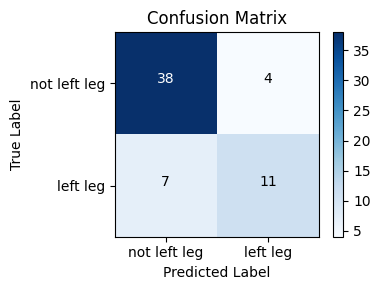

Accuracy:  0.8166666666666667


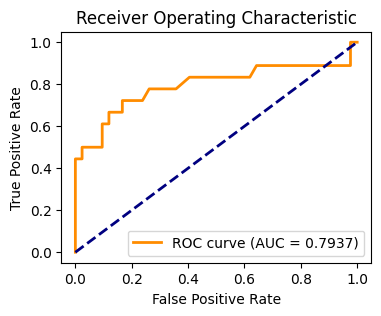

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import numpy as np

relabeled_OoM = dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])
target_label = list(relabeled_OoM.value_counts().index)[0]
labels = np.array(relabeled_OoM == target_label).astype(int)
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)


with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
accuracy = accuracy_score(y_true, (np.array(y_score) >= 0.5).astype(int))

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ["not "+group_names[1], group_names[1]]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [40]:
ord_edge_groups = {0: [0,2,3,5], 1:[1,4,6], 2:[7,9,10,12], 3:[8,11,13], 4:[14]}
group_names = {0: "right leg", 1: "left leg", 2:"right arm", 3:"left arm", 4:"head"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}
relabeled_OoM = dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])

total_score = 0
for i in tqdm(range(len(ord_edge_groups.keys())), 'Testing every label'):
    target_label = list(relabeled_OoM.value_counts().index)[i]
    labels = np.array(relabeled_OoM == target_label).astype(int)
    features = np.array(dataset.drop('OoM',axis=1))
    n = len(labels)

    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
        results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: ",leave=False))

    # Separate the true labels and predicted labels from the results
    y_true, y_score = zip(*results)

    confusion_mat = confusion_matrix(y_true, (np.array(y_score) >= 0.5).astype(int), labels=[0, 1])
    total_score += confusion_mat[1][1]
print(total_score/len(dataset))

Testing every label:   0%|          | 0/5 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

0.4


LOOCV:   0%|          | 0/60 [00:00<?, ?it/s]

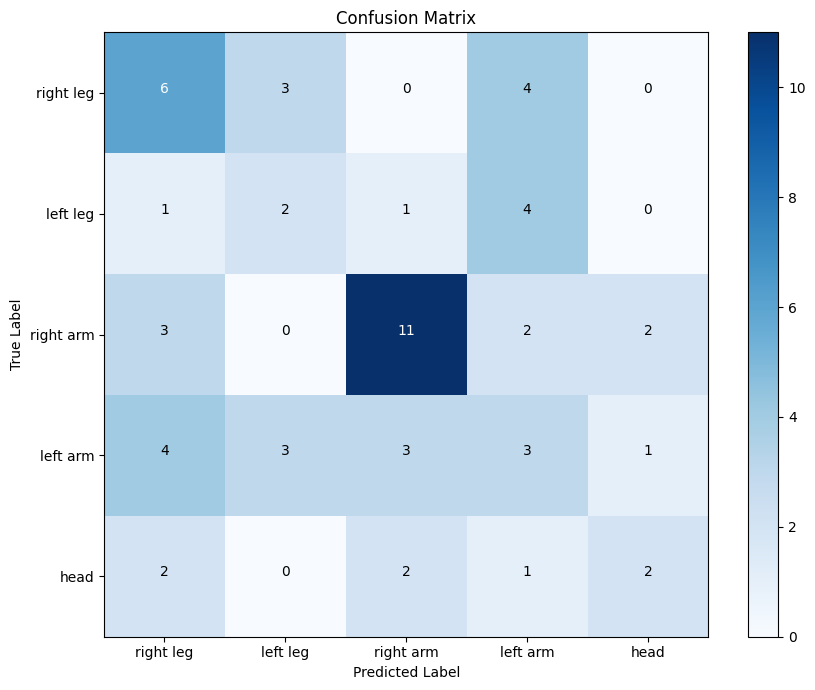

Accuracy:  0.4


ValueError: multiclass format is not supported

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import numpy as np

ord_edge_groups = {0: [0,2,3,5], 1:[1,4,6], 2:[7,9,10,12], 3:[8,11,13], 4:[14]}
group_names = {0: "right leg", 1: "left leg", 2:"right arm", 3:"left arm", 4:"head"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}

relabeled_OoM = dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label])
#target_label = list(relabeled_OoM.value_counts().index)[0]
labels = np.array(relabeled_OoM).astype(int)
features = np.array(dataset.drop('OoM',axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []


with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    results = list(tqdm(executor.map(train_and_predict, range(n)), total=n, desc="LOOCV: "))

# Separate the true labels and predicted labels from the results
y_true, y_score = zip(*results)

# Print the confusion matrix and precision
confusion_mat = confusion_matrix(y_true, y_score, labels=[0, 1, 2, 3, 4])
accuracy = accuracy_score(y_true, y_score)

# Plot the confusion matrix
plt.figure(figsize=(9, 7))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = list(group_names.values())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Show the plot
plt.show()

print("Accuracy: ", accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()